# Vector Quantized Variational Autoencoder (VQVAE) for compression and decompression of images

The goal is faster retrieval, comparison and memory efficiency

In [1]:
from keras import layers, Input, Model, Sequential
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.metrics import Mean, MAE
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        # Initialize the embeddings to quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculates the vector quantization loss and add that to the layer
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        #  Add the calculation to the layer
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

    def get_config(self):
        return {
            'num_embeddings': self.num_embeddings,
            'embedding_dim': self.embedding_dim,
            'beta': self.beta
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [5]:
def get_model_encoder(latent_dim, input_shape):
    block_encoder = Sequential([
    Input(shape=input_shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", strides=2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(latent_dim, 3, padding="same", name=f'le{latent_dim}')],
        name='block_encoder')

    return Model(block_encoder.inputs, block_encoder.outputs, name='model_encoder')


def get_model_decoder(model_encoder_out_shape):
    block_decoder = Sequential([
        Input(shape=model_encoder_out_shape),
        layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        layers.Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding="same"),
        tf.keras.layers.BatchNormalization(),
        layers.Conv2DTranspose(filters=3, kernel_size=3, padding="same")
    ], name='block_decoder')

    return Model(block_decoder.inputs, block_decoder.outputs, name='model_decoder')

In [7]:
def get_vqvae(shape, latent_dim, num_embeddings, model_encoder, model_decoder):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    inputs = Input(shape=shape)
    encoder_outputs = model_encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = model_decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")

In [8]:
class VQVAETrainer(Model):
    def __init__(self, data_shape, train_variance, latent_dim, num_embeddings, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.model_encoder = get_model_encoder(self.latent_dim, input_shape=data_shape)
        self.model_decoder = get_model_decoder(self.model_encoder.output.shape[1:])

        self.vqvae = get_vqvae(
            shape=data_shape,
            latent_dim=self.latent_dim,
            num_embeddings=self.num_embeddings,
            model_encoder=self.model_encoder,
            model_decoder=self.model_decoder)

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

Dataset

In [9]:
(x_train, _), (x_test, _) = cifar10.load_data()

# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

Params

In [ ]:
data_variance = np.var(x_train / 255.0)
latent_dim = 15
num_embeddings = 256

Initialization of trainer

In [12]:
# vqvae_trainer = VQVAETrainer(data_shape=x_train.shape[1:], train_variance=data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer = VQVAETrainer(data_shape=x_train.shape[1:], train_variance=data_variance, latent_dim=latent_dim, num_embeddings=num_embeddings)

Neural characteristics

In [13]:
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model_encoder (Functional)  (None, 8, 8, 15)          28431     
                                                                 
 vector_quantizer (VectorQua  (None, 8, 8, 15)         3840      
 ntizer)                                                         
                                                                 
 model_decoder (Functional)  (None, 32, 32, 3)         28419     
                                                                 
Total params: 60,690
Trainable params: 60,306
Non-trainable params: 384
_________________________________________________________________


Compile trainer

In [ ]:
vqvae_trainer.compile(optimizer=Adam())

Training process

In [14]:
history = vqvae_trainer.fit(x_train_scaled,
                            epochs=100,
                            batch_size=128)

Epoch 1/100
391/391 [==============================] - 11s 8ms/step - loss: 13.4522 - reconstruction_loss: 0.3958 - vqvae_loss: 12.9070
Epoch 2/100
391/391 [==============================] - 3s 8ms/step - loss: 0.7280 - reconstruction_loss: 0.2336 - vqvae_loss: 0.4759
Epoch 3/100
391/391 [==============================] - 3s 8ms/step - loss: 0.4861 - reconstruction_loss: 0.1741 - vqvae_loss: 0.3035
Epoch 4/100
391/391 [==============================] - 3s 8ms/step - loss: 0.3982 - reconstruction_loss: 0.1480 - vqvae_loss: 0.2441
Epoch 5/100
391/391 [==============================] - 3s 8ms/step - loss: 0.3182 - reconstruction_loss: 0.1302 - vqvae_loss: 0.1843
Epoch 6/100
391/391 [==============================] - 3s 9ms/step - loss: 0.3045 - reconstruction_loss: 0.1199 - vqvae_loss: 0.1826
Epoch 7/100
391/391 [==============================] - 3s 8ms/step - loss: 0.3047 - reconstruction_loss: 0.1133 - vqvae_loss: 0.1899
Epoch 8/100
391/391 [==============================] - 3s 8ms/step

# Evaluation

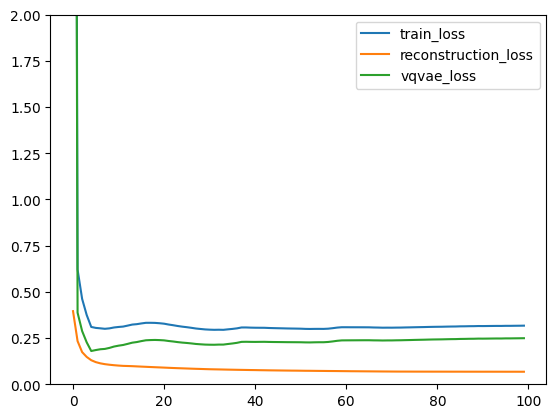

In [15]:
pd.DataFrame({
    'train_loss': history.history["loss"],
    'reconstruction_loss': history.history["reconstruction_loss"],
    'vqvae_loss': history.history["vqvae_loss"]}).plot(ylim=(0, 2));

# Store models

In [ ]:
BASE_DIR = '../models'
COMPRESSOR_MODEL_NAME = 'compressor_model_v'
COMPRESSOR_DECODER_NAME = 'compressor_decoder_v'

In [16]:
decoder = vqvae_trainer.vqvae.get_layer('model_decoder')

In [17]:
version = glob.glob(f'{BASE_DIR}*').__len__() + 1

file_path = f'{BASE_DIR}/{COMPRESSOR_MODEL_NAME}{version}'
vqvae_trainer.vqvae.save(file_path)

INFO:tensorflow:Assets written to: ../models/lossless_compressor_model_v3\assets


INFO:tensorflow:Assets written to: ../models/lossless_compressor_model_v3\assets


In [18]:
decoder.save(f'{BASE_DIR}/{COMPRESSOR_DECODER_NAME}{version}')

INFO:tensorflow:Assets written to: ../models/lossless_compressor_decoder_v3\assets


INFO:tensorflow:Assets written to: ../models/lossless_compressor_decoder_v3\assets


# Load models and layers

In [19]:
vqvae_model = load_model(f'{BASE_DIR}/{COMPRESSOR_MODEL_NAME}{version}')

# both decoder_model and vqvae_model.get_layer('decoder') can be used for decompression, remember with the separation of decoder_model will require less memory storage
decoder_model = load_model(f'{BASE_DIR}/{COMPRESSOR_DECODER_NAME}{version}', compile=False)

In [20]:
encoder = vqvae_model.get_layer("model_encoder")
quantizer = vqvae_model.get_layer("vector_quantizer")
decoder = vqvae_model.get_layer('model_decoder')

In [21]:
def get_code_indices(flattened_inputs, embeddings):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

# Test

In [35]:
# Select random sample
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]

# Predict encodes
encoded_outputs = encoder.predict(test_images)

# Restructure encodes dims
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])

# Get code indices
codebook_indices = get_code_indices(flat_enc_outputs, quantizer.embeddings)

# Restructure code indices dims
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

1/1 [==============================] - 0s 65ms/step


In [68]:
# Quantizers' embeddings dims in Tensor
quantizer.embeddings.shape

TensorShape([15, 256])

In [65]:
# Retrieve quantized latents
quantized_latents = quantizer(encoded_outputs)

# Reconstruct y-hat from quantization
reconstructed_img = decoder.predict(quantized_latents)

1/1 [==============================] - 0s 22ms/step


Quantized Tensor shape

In [37]:
quantized_latents.shape, codebook_indices.shape, reconstructed_img.shape, test_images.shape

(TensorShape([10, 8, 8, 15]), (10, 8, 8), (10, 32, 32, 3), (10, 32, 32, 3))

Compression of

In [38]:
8*8*15, 32*32*3

(960, 3072)

(32, 32, 3) (8, 8) (32, 32, 3)


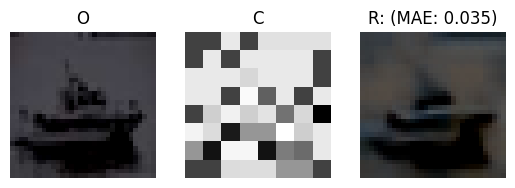

(32, 32, 3) (8, 8) (32, 32, 3)


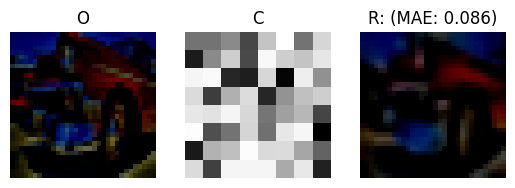

(32, 32, 3) (8, 8) (32, 32, 3)


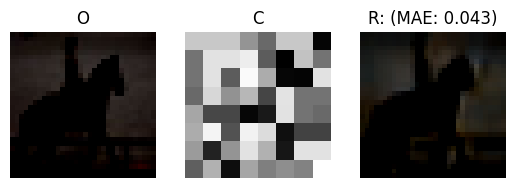

(32, 32, 3) (8, 8) (32, 32, 3)


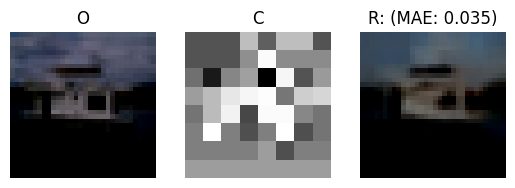

(32, 32, 3) (8, 8) (32, 32, 3)


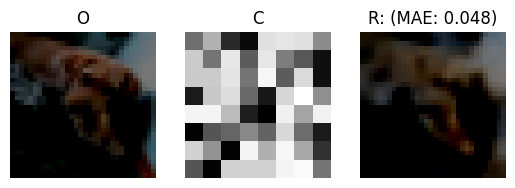

(32, 32, 3) (8, 8) (32, 32, 3)


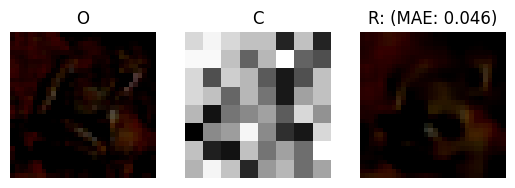

(32, 32, 3) (8, 8) (32, 32, 3)


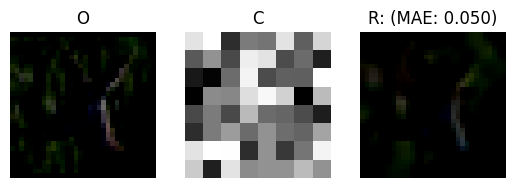

(32, 32, 3) (8, 8) (32, 32, 3)


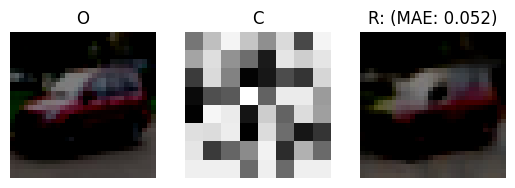

(32, 32, 3) (8, 8) (32, 32, 3)


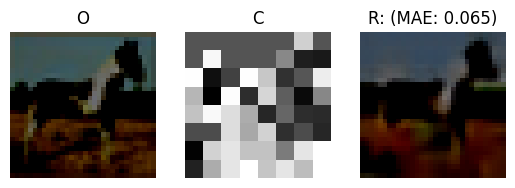

(32, 32, 3) (8, 8) (32, 32, 3)


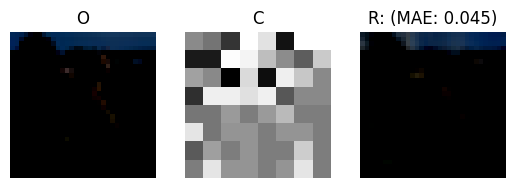

In [39]:
for i in range(len(test_images)):
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i], cmap="Greys_r")
    plt.title(f"O")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(codebook_indices[i], cmap="Greys_r")
    plt.title(f"C")
    plt.axis("off")

    mean_absolute_error = MAE(test_images[i].flatten(), reconstructed_img[i].flatten())
    mean_absolute_error = np.round(mean_absolute_error.numpy(), 3)

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_img[i], cmap="Greys_r")
    plt.title(f"R: (MAE: {f'{mean_absolute_error}'[:5]})")

    print(test_images[i].shape, codebook_indices[i].shape, reconstructed_img[i].shape)

    plt.axis("off")
    plt.show()